In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# Read raw data

In [2]:
data_path = glob.glob("data/neutral_runs_conditionLevel_FNSandFNT/*.txt")
print("The number of subjects (files): {0}".format(len(data_path)))

The number of subjects (files): 109


In [3]:
# read into dataframe
raw = []
for i in data_path:
    subj = i.split("/")[2].split(".")[0]
    temp = pd.read_csv(i, delimiter = "\t")
    temp["Subj"] = subj
    
    raw.append(temp)
    
raw = pd.concat(raw, axis = 0)
raw.head()

,ROI_name,Cond_type,0s,1.25s,2.5s,3.75s,5s,6.25s,7.5s,8.75s,10s,11.25s,12.5s,13.75s,15s,16.25s,Subj
0,R_med._OFC,FNS,-0.017370,-0.145450,-0.130680,0.000228,0.125360,-0.124750,-0.166500,-0.008064,0.19188,-0.039124,-0.22335,-0.094677,-0.316900,-0.183660,MAX147
1,L_med._OFC,FNS,0.388470,-0.082092,0.649110,-0.077994,0.145390,0.133670,-0.128480,-0.318320,0.19076,0.168080,0.20085,-0.071624,-0.066702,-0.167220,MAX147
2,R_lat._OFC,FNS,-0.074605,-0.012770,-0.056217,-0.149080,0.097791,0.500660,0.070173,0.050365,0.17332,0.111840,0.17361,0.384270,0.217920,-0.020867,MAX147
3,L_lat._OFC,FNS,0.087164,-0.220730,0.207180,-0.239000,-0.073954,0.027900,-0.157300,0.053071,-0.13818,0.096835,0.16151,0.114520,0.058860,0.129220,MAX147
4,M_vmPFC1,FNS,-0.159430,-0.146720,0.028033,-0.020549,-0.129970,0.085009,0.043782,-0.016835,-0.24556,-0.303250,-0.68059,-0.621760,-0.762940,-0.794960,MAX147


In [4]:
# transfer raw data into long format

timepoint = [i for i in raw.columns if "s" in i]

df = pd.melt(raw, id_vars = ["Subj", "ROI_name", "Cond_type"], value_vars = timepoint, 
             var_name = "Time", value_name = "response")
df["Time"] = df["Time"].apply(lambda x: np.fromstring(x, sep = "s")[0])

In [5]:
df["response"].describe()

count    259420.000000
mean         -0.032687
std           0.240215
min          -3.077600
25%          -0.152930
50%          -0.025354
75%           0.095842
max           3.185800
Name: response, dtype: float64

# Min-shifted (No effects for the diff coding)

In [6]:
min_df = df.groupby(["Subj", "ROI_name"])["response"].min().reset_index()
min_df = min_df.rename(columns = {"response": "minimum"})

df = df.merge(min_df, how = "left", on = ["Subj", "ROI_name"])

In [7]:
df["offset"] = df["response"] - df["minimum"]

In [8]:
df.head()

,Subj,ROI_name,Cond_type,Time,response,minimum,offset
0,MAX147,R_med._OFC,FNS,0.0,-0.017370,-0.31690,0.299530
1,MAX147,L_med._OFC,FNS,0.0,0.388470,-0.60797,0.996440
2,MAX147,R_lat._OFC,FNS,0.0,-0.074605,-0.18776,0.113155
3,MAX147,L_lat._OFC,FNS,0.0,0.087164,-0.45423,0.541394
4,MAX147,M_vmPFC1,FNS,0.0,-0.159430,-0.79496,0.635530


# Combining STAI scores

In [9]:
import re

STAI_path = '/data/bswift-1/Pessoa_Lab/MAX/ROI_masks/MAX_ROIs_final_gm_85.nii.gz'
 
with open(STAI_path,'r') as file:
    names = re.split('\t| |\n',file.readline())

STAI=pd.read_csv(STAI_path,sep='\t',names=names[:3],skiprows=1)
STAI['Subj'] = STAI['subject'].apply(lambda ID: 'MAX{:03d}'.format(ID))
STAI.drop('subject',axis=1,inplace=True)
STAI = STAI[STAI.Subj.isin(df.Subj)]
STAI.set_index('Subj',inplace=True)
STAI.head()

,TRAIT,STATE
Subj,,
MAX101,27,22
MAX102,47,44
MAX103,33,32
MAX104,24,21
MAX105,56,28


In [10]:
# Standardize the covariates
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
STAI = pd.DataFrame(ss.fit_transform(STAI),columns=STAI.columns,index=STAI.index)
STAI.reset_index(inplace=True)
STAI.head()

,Subj,TRAIT,STATE
0,MAX101,-1.164152,-1.011495
1,MAX102,1.264414,1.539046
2,MAX103,-0.435582,0.147842
3,MAX104,-1.528437,-1.127429
4,MAX105,2.357268,-0.315893


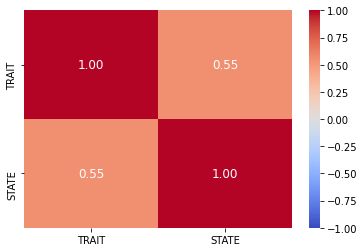

In [11]:
# Trait-State correlation 
_=sns.heatmap(STAI.corr(method='spearman'),vmin=-1,vmax=1,annot=True,fmt='.2f',cmap='coolwarm',annot_kws=dict(size=12))

In [12]:
df = df.merge(STAI, how = "left", on = ["Subj"])

## Aggregate Early/Late Periods 

This notebook aggregates responses from early (2.5-8.75s) and late periods (10-16.25s)

In [13]:
def phase(time):
    if (time >= 2.5 and time <= 8.75):
        return 'early'
    elif (time >= 10 and time <= 16.25):
        return 'late'
    else:
        return "pre_early"

In [14]:
df["Phase"] = df["Time"].apply(lambda x: phase(x))

df = df.sort_values(["Subj", "ROI_name", "Cond_type"]).reset_index(drop=True)

df.head()

,Subj,ROI_name,Cond_type,Time,response,minimum,offset,TRAIT,STATE,Phase
0,MAX101,L_ACC,FNS,0.00,-0.030393,-0.17858,0.148187,-1.164152,-1.011495,pre_early
1,MAX101,L_ACC,FNS,1.25,0.058565,-0.17858,0.237145,-1.164152,-1.011495,pre_early
2,MAX101,L_ACC,FNS,2.50,0.069600,-0.17858,0.248180,-1.164152,-1.011495,early
3,MAX101,L_ACC,FNS,3.75,0.016329,-0.17858,0.194909,-1.164152,-1.011495,early
4,MAX101,L_ACC,FNS,5.00,0.032171,-0.17858,0.210751,-1.164152,-1.011495,early


In [27]:
df.to_csv("data/MAX_neutral_estimated_response.txt", sep = ",", index = False)

In [15]:
agg_df = df.groupby(["Subj", "ROI_name", "Cond_type", "Phase", "TRAIT", "STATE"])[["offset", "response"]].sum().reset_index()
agg_df["cond"] = agg_df["Cond_type"].apply(lambda x: -0.5 if x == "FNS" else 0.5)
agg_df = agg_df[agg_df["Phase"] != "pre_early"]

In [16]:
agg_df.head()

,Subj,ROI_name,Cond_type,Phase,TRAIT,STATE,offset,response,cond
0,MAX101,L_ACC,FNS,early,-1.164152,-1.011495,0.841614,-0.229866,-0.5
1,MAX101,L_ACC,FNS,late,-1.164152,-1.011495,0.864770,-0.206710,-0.5
3,MAX101,L_ACC,FNT,early,-1.164152,-1.011495,1.321465,0.249985,0.5
4,MAX101,L_ACC,FNT,late,-1.164152,-1.011495,0.907264,-0.164216,0.5
6,MAX101,L_BLBM_Amygdala,FNS,early,-1.164152,-1.011495,2.902625,0.709145,-0.5


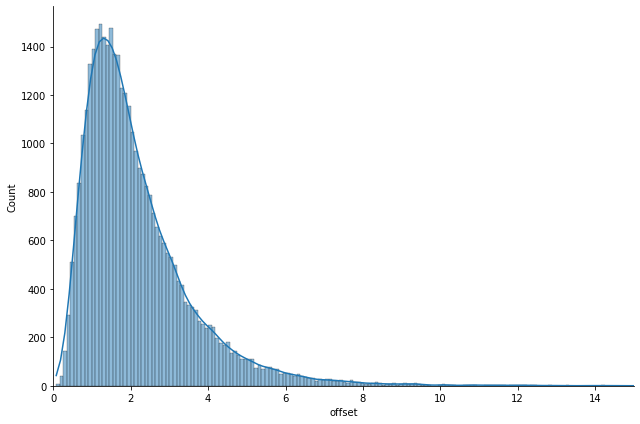

In [17]:
dist_plot = sns.displot(agg_df, x = "offset", kde = True, height = 6, aspect = 1.5)
dist_plot.set(xlim = (0, 15))

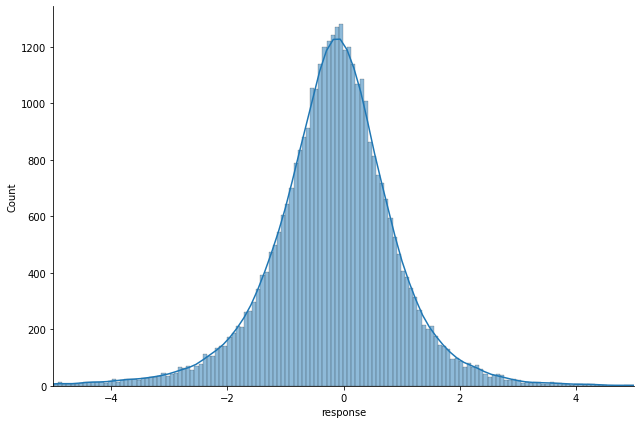

In [18]:
dist_plot = sns.displot(agg_df, x = "response", kde = True, height = 6, aspect = 1.5)
dist_plot.set(xlim = (-5, 5))

In [55]:
agg_df.to_csv("data/MAX_neutral_offset_agg_response.txt", sep = ",", index = False)

In [19]:
agg_diff_df = agg_df.merge(agg_df, on = ["Subj", "ROI_name", "Phase", "TRAIT", "STATE"])
agg_diff_df = agg_diff_df[(agg_diff_df["Cond_type_x"] == "FNS") & (agg_diff_df["Cond_type_y"] == "FNT")]
agg_diff_df["diff_res"] = agg_diff_df["response_y"] - agg_diff_df["response_x"]
agg_diff_df["diff_off"] = agg_diff_df["offset_y"] - agg_diff_df["offset_x"]
agg_diff_df = agg_diff_df[["Subj", "ROI_name", "Phase", "STATE", "TRAIT", "diff_res", "diff_off"]]

In [20]:
agg_diff_df.head()

,Subj,ROI_name,Phase,STATE,TRAIT,diff_res,diff_off
1,MAX101,L_ACC,early,-1.011495,-1.164152,0.479851,0.479851
5,MAX101,L_ACC,late,-1.011495,-1.164152,0.042494,0.042494
9,MAX101,L_BLBM_Amygdala,early,-1.011495,-1.164152,-0.627759,-0.627759
13,MAX101,L_BLBM_Amygdala,late,-1.011495,-1.164152,-2.397176,-2.397176
17,MAX101,L_BST,early,-1.011495,-1.164152,0.769533,0.769533


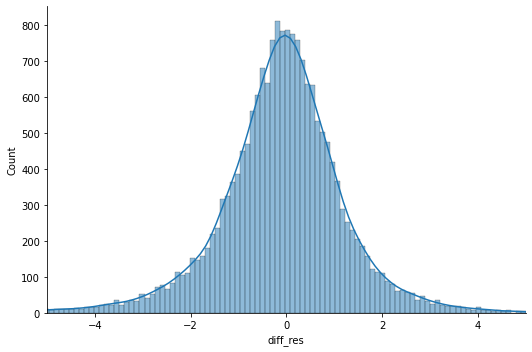

In [21]:
diff_dens = sns.displot(agg_diff_df, x = "diff_res", kde = True, height = 5, aspect = 1.5)
diff_dens.set(xlim = (-5, 5))

## Plot mean response across subjects for each TR of original/offset dataset

In [22]:
def get_mean_df(df, min_shift = True, diff = False):
    '''
    Takes estimated response dataframe and outputs an aggregated 
    dataframe with mean response across subjects along with error bounds.
    '''
    
    if min_shift:
        beta = "offset"
    else:
        beta = "response"
        
    from scipy.stats import sem
    def sem_rmna(df):
        return sem(df.dropna())
    
    if diff:
        mean_df = df.groupby(['ROI_name', 'Time'])[beta].agg([np.mean, sem_rmna,"count"]).reset_index()
    else:
        mean_df = df.groupby(['ROI_name', 'Cond_type', 'Time'])[beta].agg([np.mean, sem_rmna,"count"]).reset_index()
        
    from scipy.stats import t as tdist
    critT = mean_df["count"].apply(lambda x: tdist(df = x - 1).ppf(0.975))
    mean_df['lower_bound'] = mean_df['mean'] - critT*mean_df['sem_rmna']
    mean_df['upper_bound'] = mean_df['mean'] + critT*mean_df['sem_rmna']
    
    return mean_df

In [23]:
orig_mean_df = get_mean_df(df, min_shift = False)
offset_mean_df = get_mean_df(df)

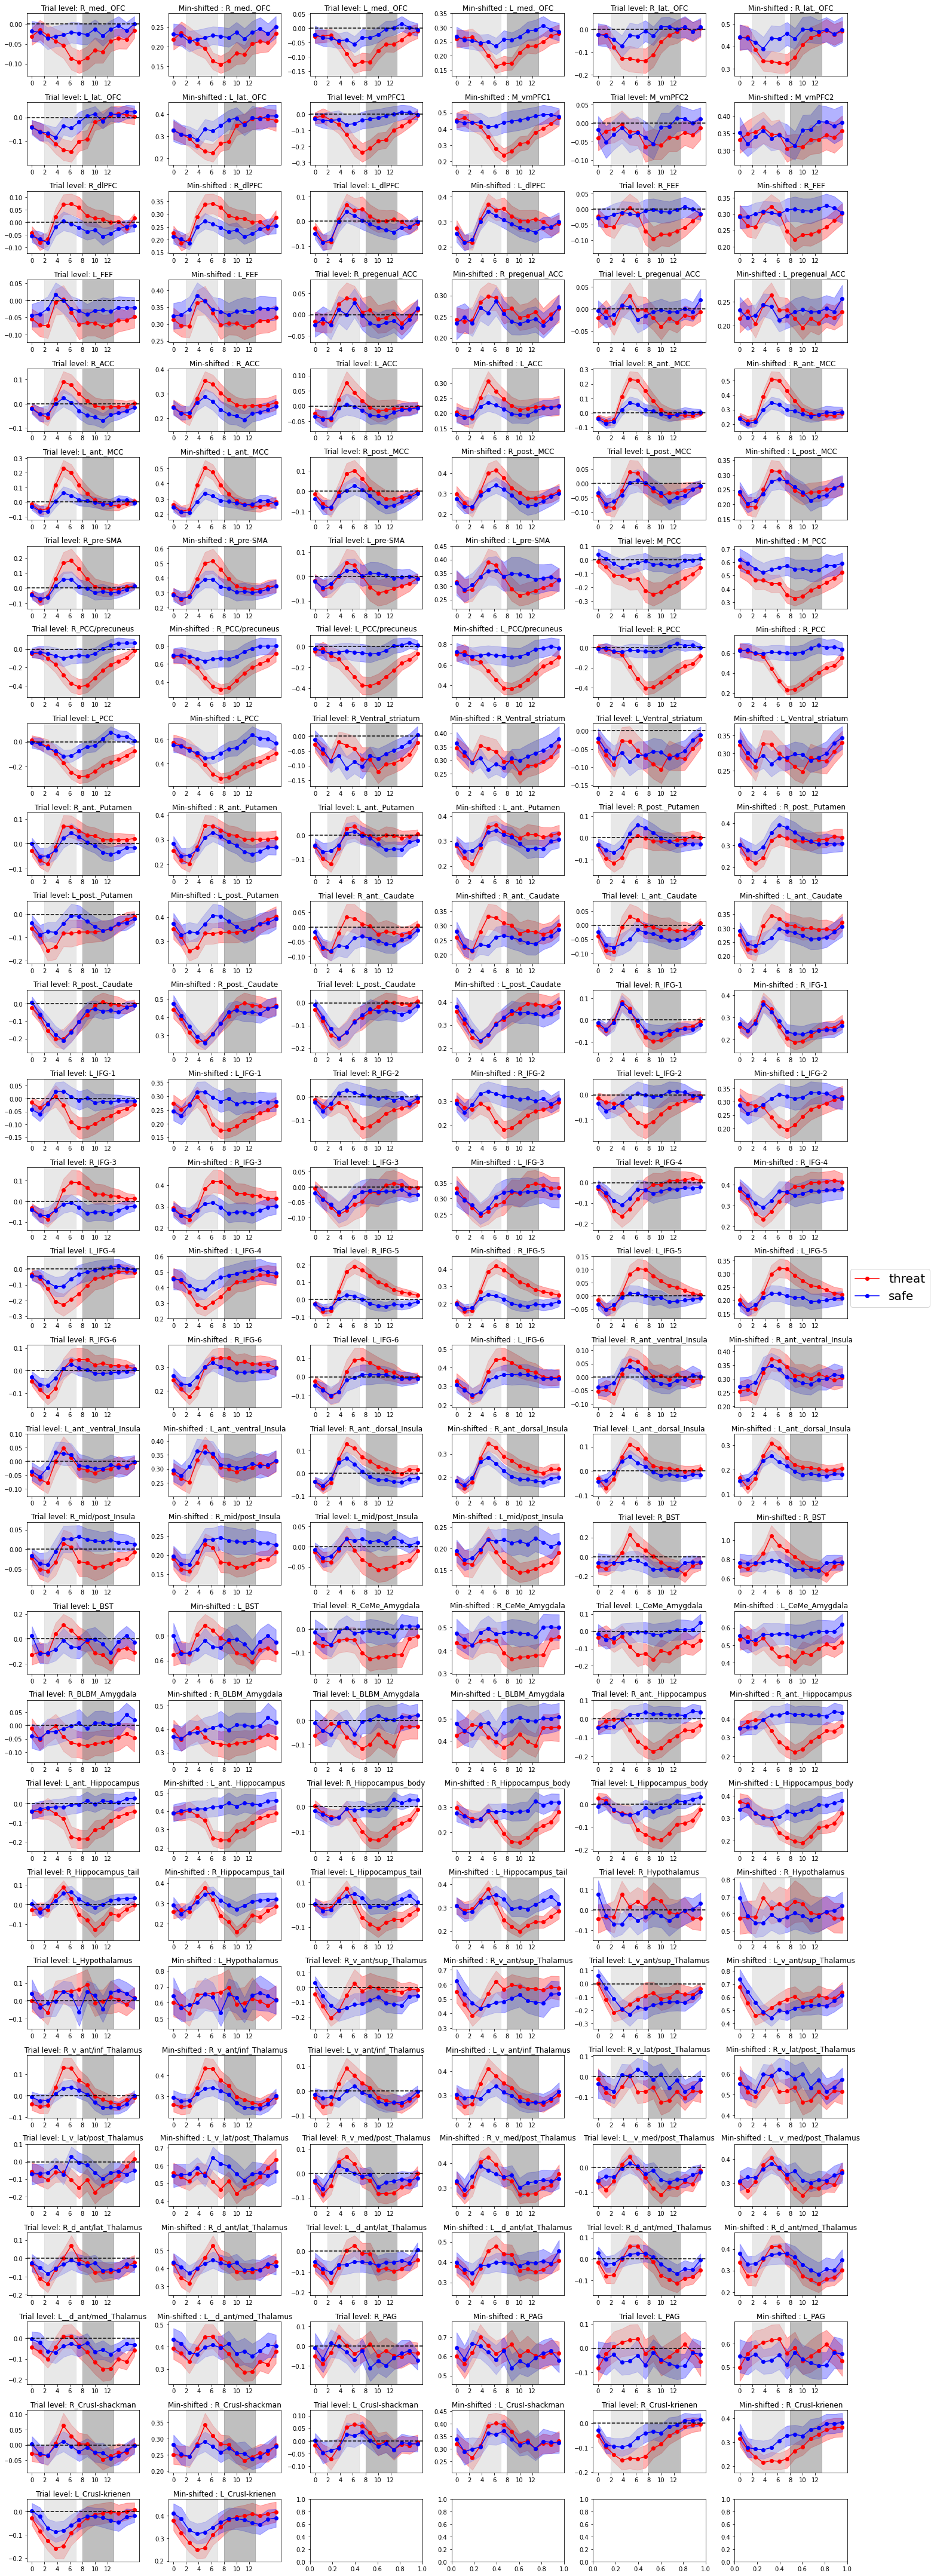

In [24]:
fig, axes = plt.subplots(nrows = 29, ncols= 6, figsize = (20, 60), sharey = False)
axes = axes.flatten()
fig.subplots_adjust(wspace = 0.2, hspace = 0.35)

ROIs = raw["ROI_name"].unique()

for i, roi in enumerate(ROIs):
    ii = i*2
    
    orig_threat_df = orig_mean_df[(orig_mean_df['ROI_name'] == roi) & (orig_mean_df['Cond_type'] == 'FNT')]
    orig_safe_df = orig_mean_df[(orig_mean_df['ROI_name'] == roi) & (orig_mean_df['Cond_type'] == 'FNS')]
    axes[ii].plot("Time", "mean", data = orig_threat_df, label ='threat', color ='red', marker='o')
    axes[ii].fill_between("Time", 'lower_bound', 'upper_bound', data = orig_threat_df, alpha=0.3, color='red')
    axes[ii].plot("Time", "mean", data = orig_safe_df, label = 'safe',color = 'blue',marker = 'o')
    axes[ii].fill_between("Time", 'lower_bound', 'upper_bound', data = orig_safe_df, alpha=0.3, color='blue')
    axes[ii].axhline(y = 0,linestyle='--',color='k')
    axes[ii].axvspan(xmin = 2, xmax = 7, color = 'lightgray', alpha=0.5)
    axes[ii].axvspan(xmin = 8, xmax = 13, color = 'gray', alpha=0.5)
    axes[ii].set_title('Trial level: ' + roi)
    axes[ii].set_xticks([0, 2, 4, 6, 8, 10, 12])
    
    offset_threat_df = offset_mean_df[(offset_mean_df['ROI_name'] == roi) & (offset_mean_df['Cond_type'] == 'FNT')]
    offset_safe_df = offset_mean_df[(offset_mean_df['ROI_name'] == roi) & (offset_mean_df['Cond_type'] == 'FNS')]
    axes[ii + 1].plot("Time", "mean", data = offset_threat_df, label ='threat', color ='red', marker='o')
    axes[ii + 1].fill_between("Time", 'lower_bound', 'upper_bound', data = offset_threat_df, alpha=0.3, color='red')
    axes[ii + 1].plot("Time", "mean", data = offset_safe_df, label = 'safe',color = 'blue',marker = 'o')
    axes[ii + 1].fill_between("Time", 'lower_bound', 'upper_bound', data = offset_safe_df, alpha=0.3, color='blue')
    axes[ii + 1].axvspan(xmin = 2, xmax = 7, color = 'lightgray', alpha = 0.5)
    axes[ii + 1].axvspan(xmin = 8, xmax = 13, color = 'gray', alpha = 0.5)
    axes[ii + 1].set_title('Min-shifted : ' + roi)
    axes[ii + 1].set_xticks([0, 2, 4, 6, 8, 10, 12])

_ = fig.tight_layout()
_ = fig.legend(axes[i].get_legend_handles_labels()[1], 
               loc = 'center right', fontsize = 20, bbox_to_anchor=(1.09, 0.5))